# <font color='purple'>CoyneLab_iPSC_patients_TDP43_PB Preprocessing QC statistics </font> 
### October 2024

In [1]:
import os
NOVA_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps'
NOVA_DATA_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps'

LOGS_PATH = os.path.join(NOVA_DATA_HOME, "outputs/preprocessing/AlyssaCoyne/logs/preprocessing_CoyneLab_iPSC_patients_TDP43_PB_7tiles/")
PLOT_PATH = os.path.join(NOVA_DATA_HOME, "outputs/preprocessing/AlyssaCoyne/logs/preprocessing_CoyneLab_iPSC_patients_TDP43_PB_7tiles/plots")

NOVA_HOME = '/home/labs/hornsteinlab/Collaboration/NOVA_Oz/NOVA'
NOVA_DATA_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps'
LOGS_PATH = os.path.join(NOVA_HOME, 'logs', 'Alyscoyn')
PLOT_PATH = os.path.join(NOVA_HOME, 'src', 'preprocessing', 'notebooks','figures','Alyscoyn_80pct')


os.chdir(NOVA_HOME)

import pandas as pd
import contextlib
import io
from IPython.display import display, Javascript
import seaborn as sns
from tools.preprocessing_tools.qc_reports.qc_utils import log_files_qc, run_validate_folder_structure, display_diff, sample_and_calc_variance, \
                                                show_site_survival_dapi_brenner, show_site_survival_dapi_cellpose, \
                                                show_site_survival_dapi_tiling, show_site_survival_target_brenner, \
                                                calc_total_sums, plot_filtering_heatmap, show_total_sum_tables, \
                                                plot_cell_count, plot_catplot, plot_hm_combine_batches, plot_hm, \
                                                run_calc_hist_new
                                                
from tools.preprocessing_tools.qc_reports.qc_config import AC_panels, AC_markers, AC_marker_info, AC_cell_lines, AC_cell_lines_to_cond,\
                                    AC_cell_lines_for_disp, AC_reps, AC_line_colors, AC_lines_order, AC_custom_palette,\
                                    AC_expected_dapi_raw, AC_cell_lines_to_reps
%load_ext autoreload
%autoreload 2

In [2]:
df = log_files_qc(LOGS_PATH,only_wt_cond=True)
df_dapi = df[df.marker=='DAPI']
df_target = df[df.marker!='DAPI']

reading logs of batch1

Total of 1 files were read.
Before dup handeling  (1050, 21)
After duplication removal #1: (1050, 22)
After duplication removal #2: (1050, 22)


In [3]:
# choose batches
batches = ['batch1']
batches

['batch1']

## Actual Files Validation

### Raw Files Validation

1. How many site **tiff** files do we have in each folder?
2. Are all existing files valid? (tif, at least 2049kB, not corrupetd)

batch1
Folder structure is valid.
No bad files are found.
Total Sites:  800


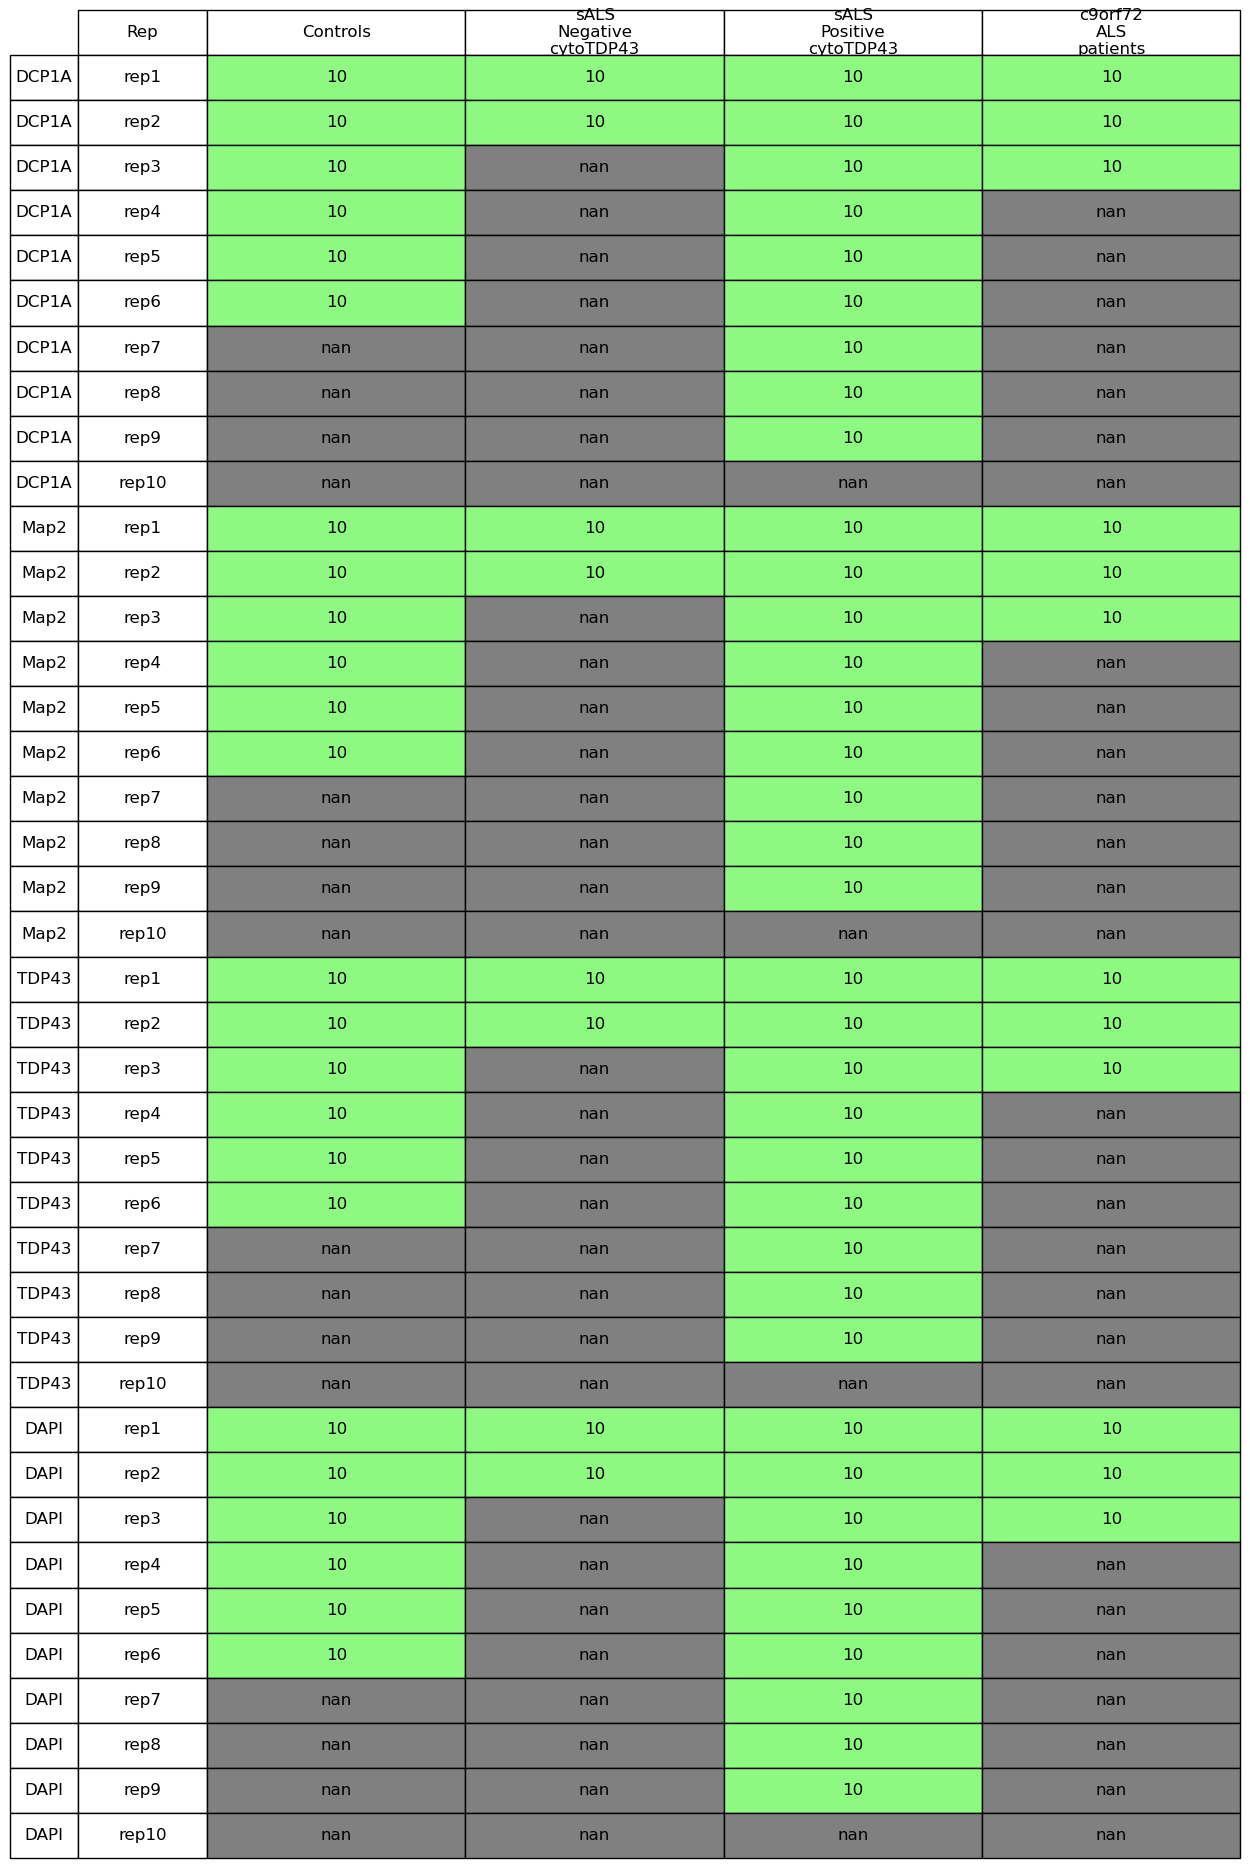

In [4]:

root_directory_raw = os.path.join(NOVA_DATA_HOME, 'input', 'images', 'raw', 'AlyssaCoyne', 'MOmaps_iPSC_patients_TDP43_PB_CoyneLab')


batches_raw = [batch.replace("_16bit_no_downsample","") for batch in batches]
raws = run_validate_folder_structure(root_directory_raw, False, AC_panels, AC_markers.copy(),PLOT_PATH, AC_marker_info,
                                    AC_cell_lines_to_cond, AC_reps, AC_cell_lines_for_disp, AC_expected_dapi_raw,
                                     batches=batches_raw, fig_width=5, cell_lines_to_reps=AC_cell_lines_to_reps,
                                    expected_count=10)

### Processed Files Validation

1. How many site **npy** files do we have in each folder? -> How many sites survived the pre-processing?
2. Are all existing files valid? (at least 100kB, npy not corrupted)

batch1
Folder structure is valid.
No bad files are found.
Total Sites:  840


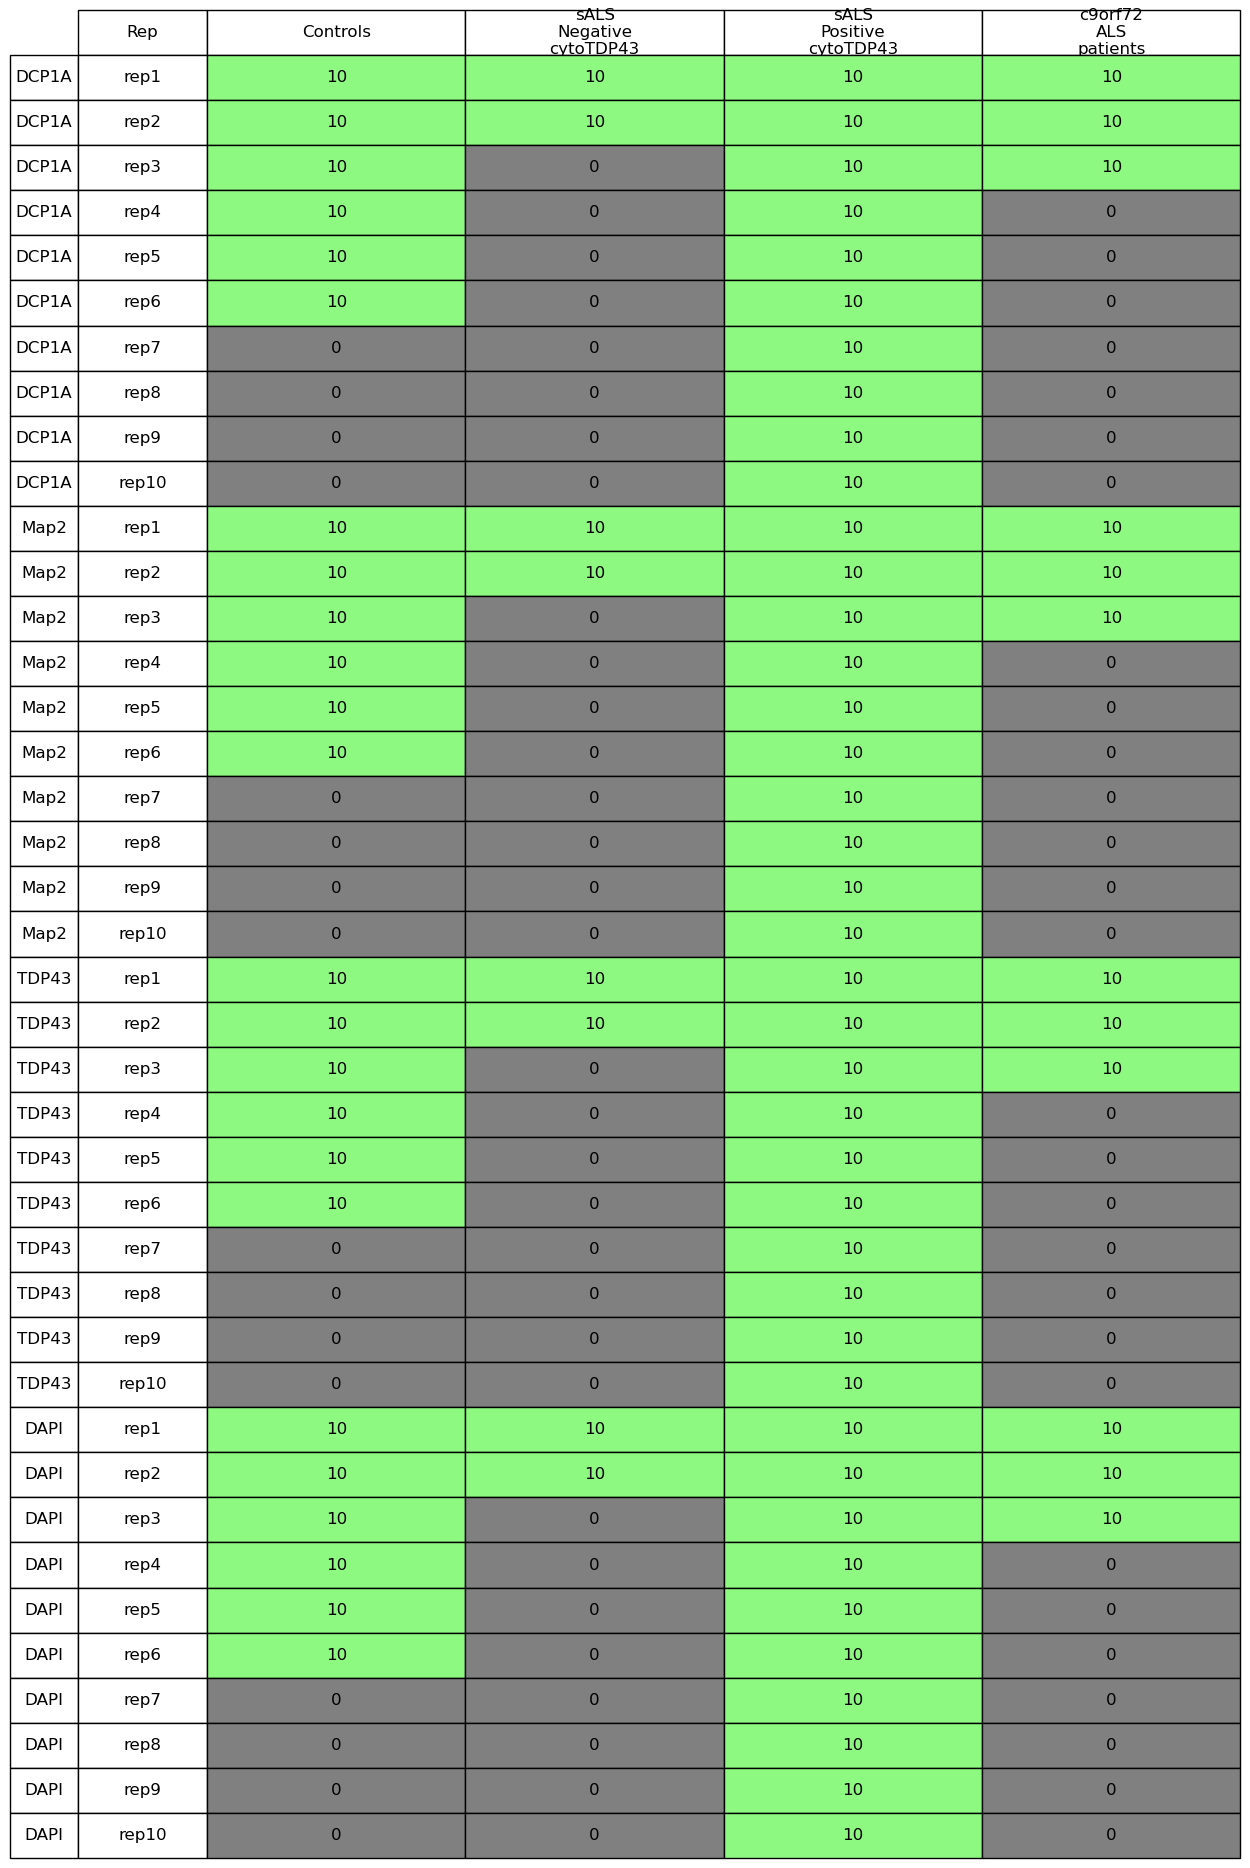

In [5]:
root_directory_proc = os.path.join(NOVA_DATA_HOME, 'input', 'images', 'processed', 'AlyssaCoyne80pct', 'MOmaps_iPSC_patients_TDP43_PB_CoyneLab_7tiles')
procs = run_validate_folder_structure(root_directory_proc, True, AC_panels, AC_markers,PLOT_PATH, AC_marker_info,
                                    AC_cell_lines_to_cond, AC_reps, AC_cell_lines_for_disp, AC_expected_dapi_raw,
                                     batches=batches, fig_width=5, cell_lines_to_reps=AC_cell_lines_to_reps,
                                    expected_count=10)

### Difference between Raw and Processed

batch1


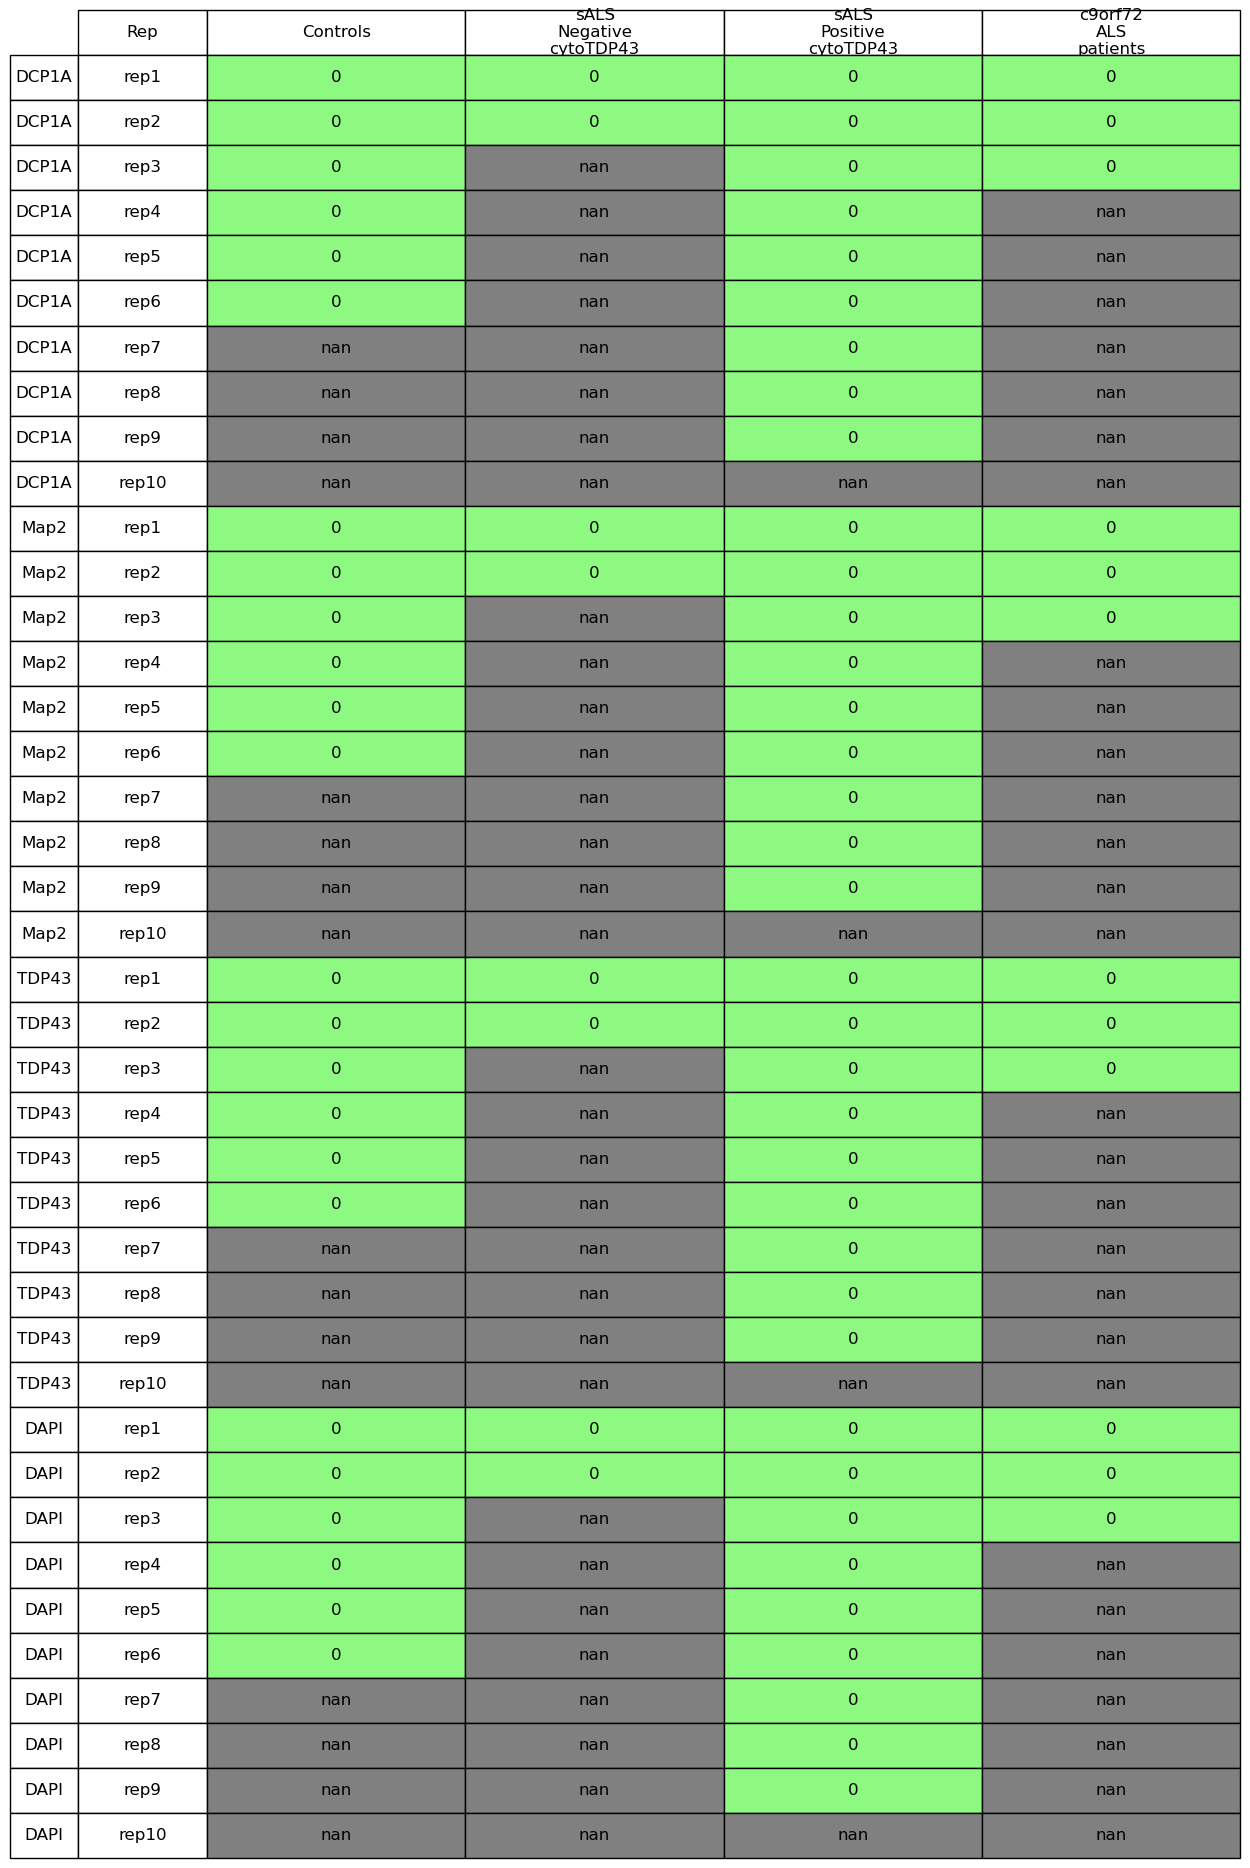

In [6]:
display_diff(batches, raws, procs, PLOT_PATH, fig_width=5)

### Variance in each batch (of processed files)

In [7]:

for batch in batches:
    with contextlib.redirect_stdout(io.StringIO()):
        var = sample_and_calc_variance(root_directory_proc, batch, 
                                       sample_size_per_markers=200, cond_count=1, rep_count=len(AC_reps), 
                                       num_markers=len(AC_markers))
    print(f'{batch} var: ',var)

batch1 var:  0.026408503507475468


## Preprocessing Filtering qc
By order of filtering

### 1. % site survival after Brenner on DAPI channel
Percentage out of the total sites

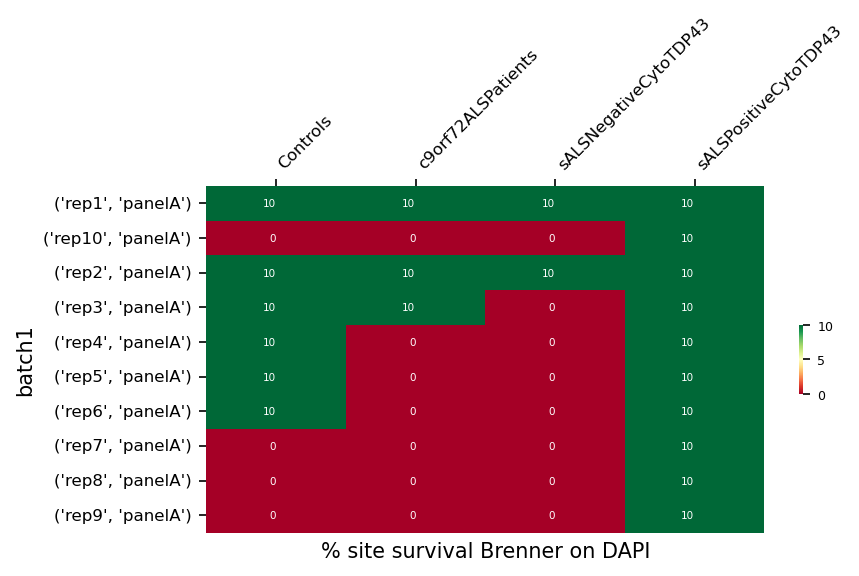

In [8]:
dapi_filter_by_brenner = show_site_survival_dapi_brenner(df_dapi,batches, AC_line_colors, AC_panels,
                                                        figsize=(6,3), reps=AC_reps, vmax=10)

### 2. % Site survival after Cellpose
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if Cellpose found 0 cells in it.**

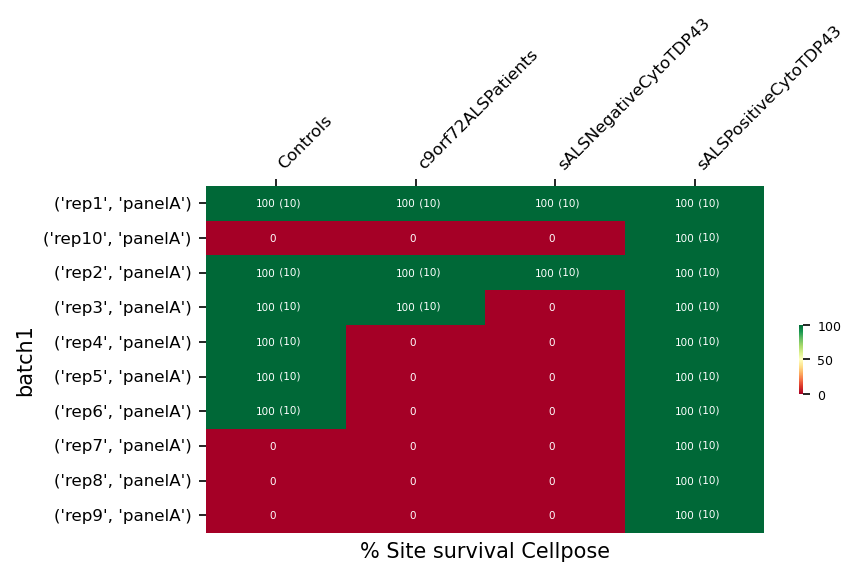

In [10]:
dapi_filter_by_cellpose = show_site_survival_dapi_cellpose(df_dapi, batches, dapi_filter_by_brenner, 
                                                           AC_line_colors, AC_panels, figsize=(6,3), reps=AC_reps)

### 3. % Site survival by tiling
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if after tiling, no tile is containing at least 85% of a cell that Cellpose detected.**

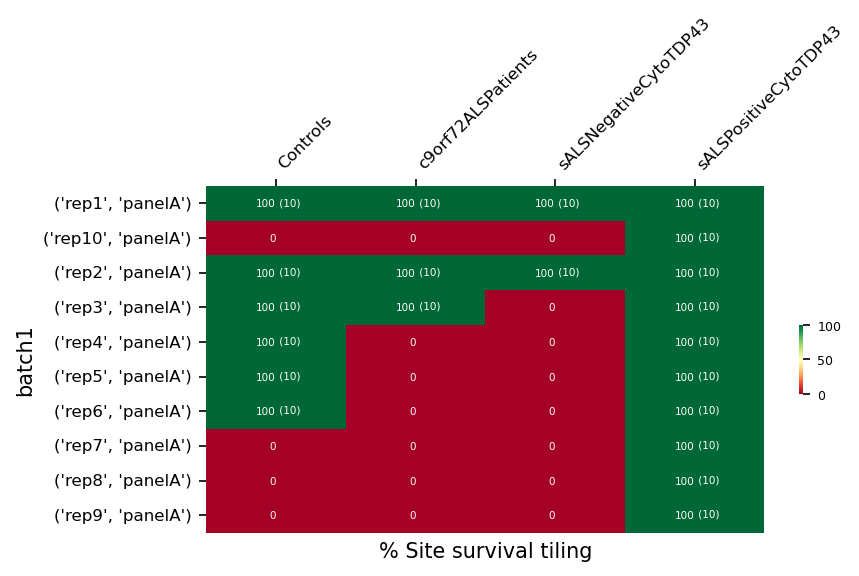

In [11]:
dapi_filter_by_tiling=show_site_survival_dapi_tiling(df_dapi, batches, dapi_filter_by_cellpose, 
                                                     AC_line_colors, AC_panels,figsize=(6,3), reps=AC_reps)

### 4. % Site survival after Brenner on target channel
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values (if different than the percentages).

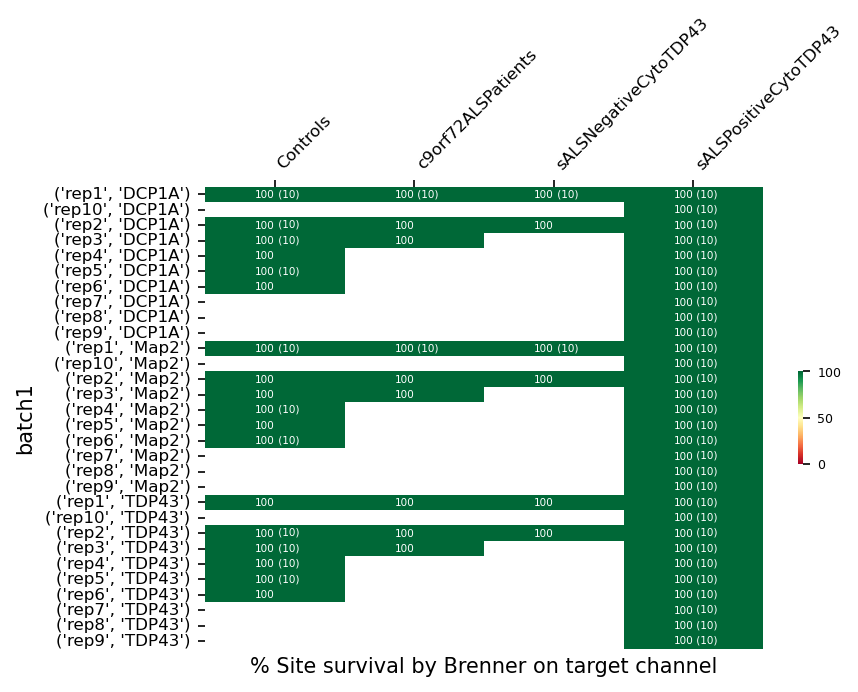

In [12]:
show_site_survival_target_brenner(df_dapi, df_target, dapi_filter_by_tiling,
                                 figsize=(6,4), markers=AC_markers)

## Statistics About the Processed Files

In [13]:
names = ['Total number of tiles', 'Total number of whole cells']
stats = ['n_valid_tiles','site_whole_cells_counts_sum','site_cell_count','site_cell_count_sum']
total_sum = calc_total_sums(df_target, df_dapi, stats, AC_markers)

### Total tiles

In [14]:
total_sum.n_valid_tiles.sum()

11804

### Total whole nuclei in tiles

In [15]:
total_sum[total_sum.marker =='DAPI'].site_whole_cells_counts_sum.sum()

1985.0

### Total nuclei in sites

In [16]:
total_sum[total_sum.marker =='DAPI'].site_cell_count.sum()

8014.0

In [17]:
show_total_sum_tables(total_sum)

,n_valid_tiles,% valid tiles,site_whole_cells_counts_sum,site_cell_count
batch1,,,,
count,84.000000,84.000000,84.000000,84.000000
mean,140.523810,1.405238,94.523810,381.619048
std,21.305849,0.213058,21.342009,73.389849
min,95.000000,0.950000,57.000000,240.000000
25%,132.000000,1.320000,82.000000,342.000000
50%,143.000000,1.430000,92.000000,372.000000
75%,153.000000,1.530000,105.000000,435.000000
max,184.000000,1.840000,134.000000,507.000000
sum,11804.000000,NaN,7940.000000,32056.000000


,n valid tiles,% valid tiles,site_whole_cells_counts_sum,site_cell_count
All batches,,,,
count,84.000000,84.000000,84.000000,84.000000
mean,140.523810,1.405238,94.523810,381.619048
std,21.305849,0.213058,21.342009,73.389849
min,95.000000,0.950000,57.000000,240.000000
25%,132.000000,1.320000,82.000000,342.000000
50%,143.000000,1.430000,92.000000,372.000000
75%,153.000000,1.530000,105.000000,435.000000
max,184.000000,1.840000,134.000000,507.000000
sum,11804.000000,NaN,7940.000000,32056.000000


### Show Total Tile Counts
For each batch, cell line, replicate and markerTotal number of tiles

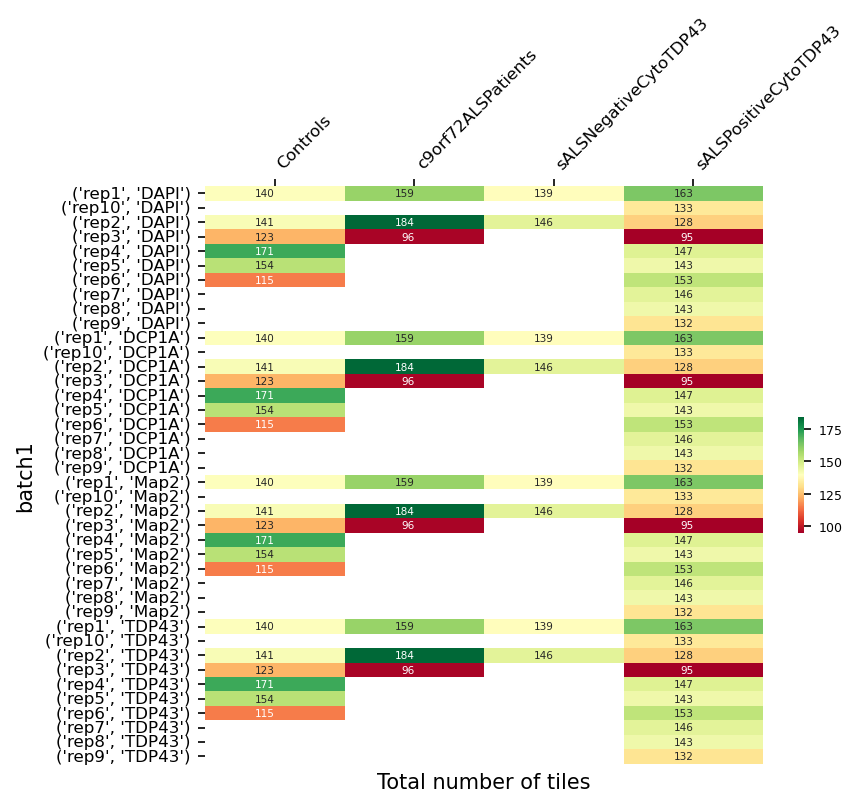

/home/labs/hornsteinlab/Collaboration/NOVA_Oz/NOVA/tools/preprocessing_tools/qc_reports/qc_utils.py:381: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
/home/labs/hornsteinlab/Collaboration/NOVA_Oz/NOVA/tools/preprocessing_tools/qc_reports/qc_utils.py:381: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


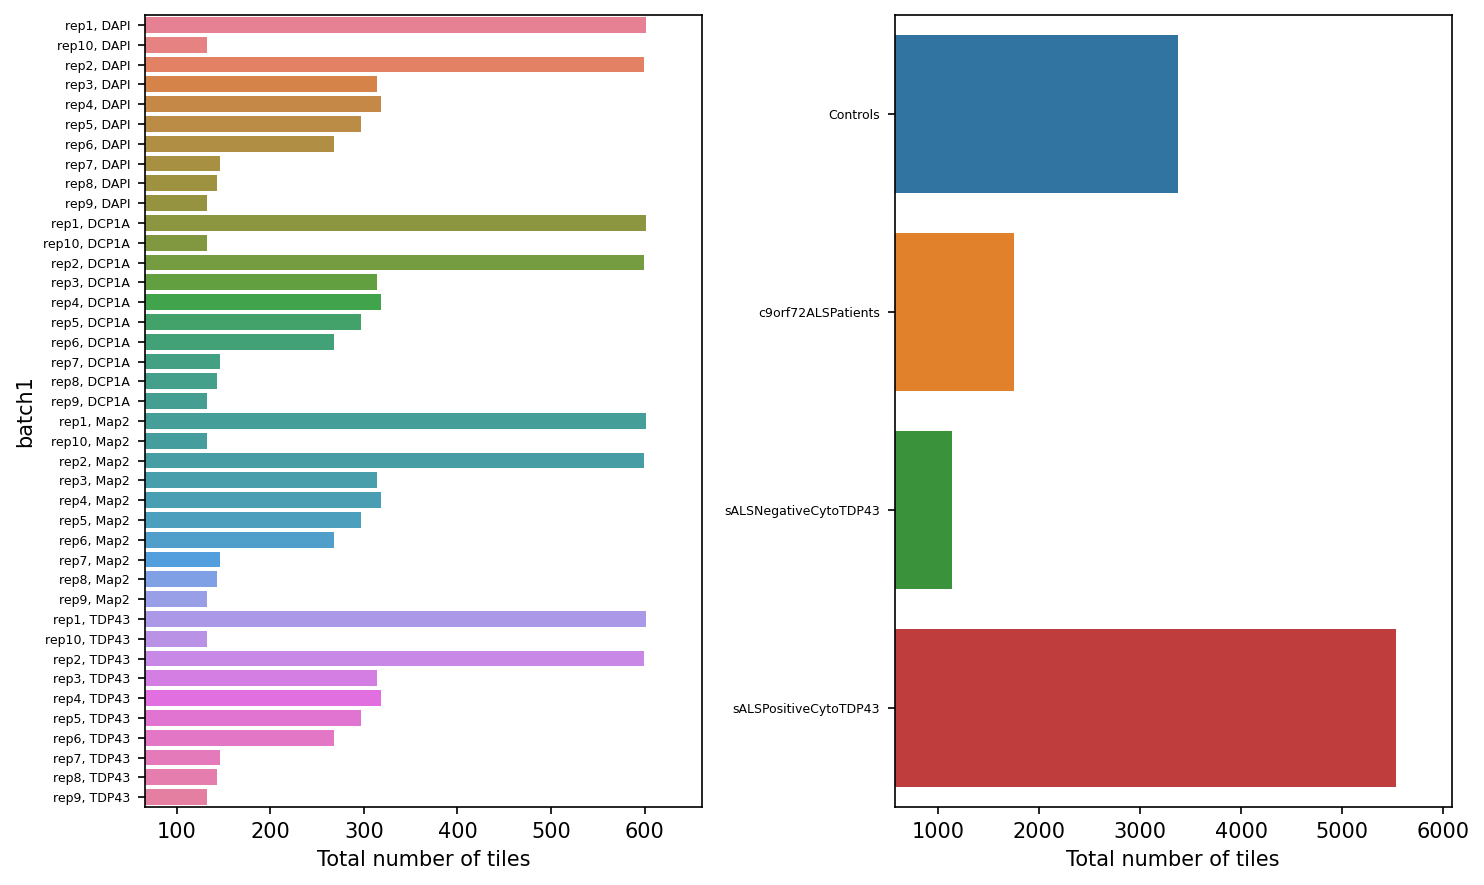

In [20]:
to_heatmap = total_sum.rename(columns={'n_valid_tiles':'index'})
plot_filtering_heatmap(to_heatmap, extra_index='marker', vmin=None, vmax=None,
                      xlabel = 'Total number of tiles', show_sum=True, figsize=(6,5))

### Show Total Whole Cell Counts
For each batch, cell line, replicate and markerTotal number of tiles

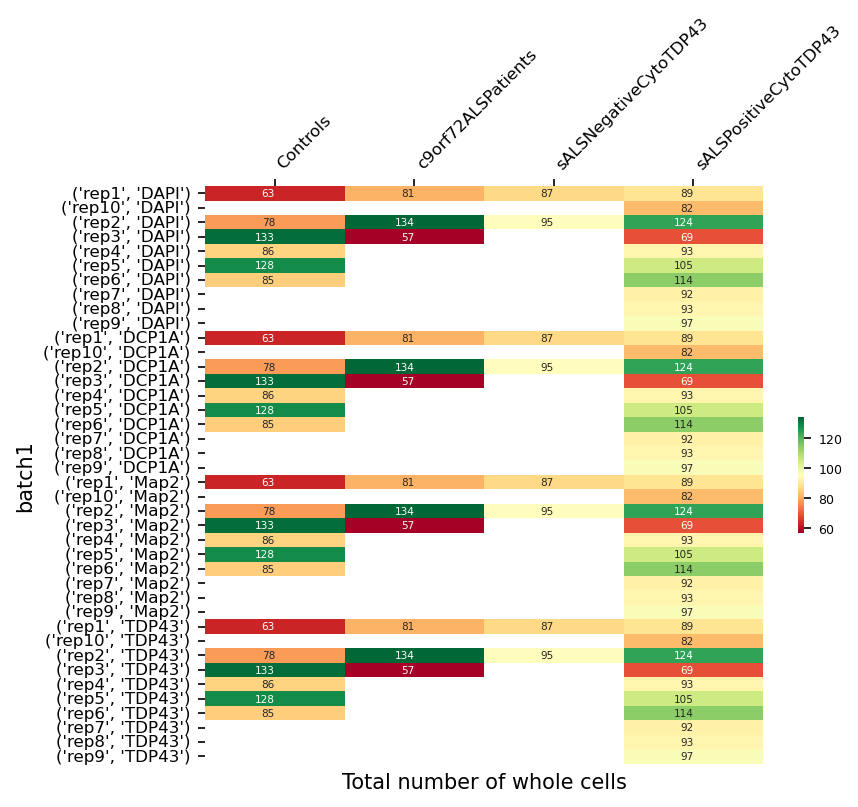

/home/labs/hornsteinlab/Collaboration/NOVA_Oz/NOVA/tools/preprocessing_tools/qc_reports/qc_utils.py:381: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
/home/labs/hornsteinlab/Collaboration/NOVA_Oz/NOVA/tools/preprocessing_tools/qc_reports/qc_utils.py:381: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


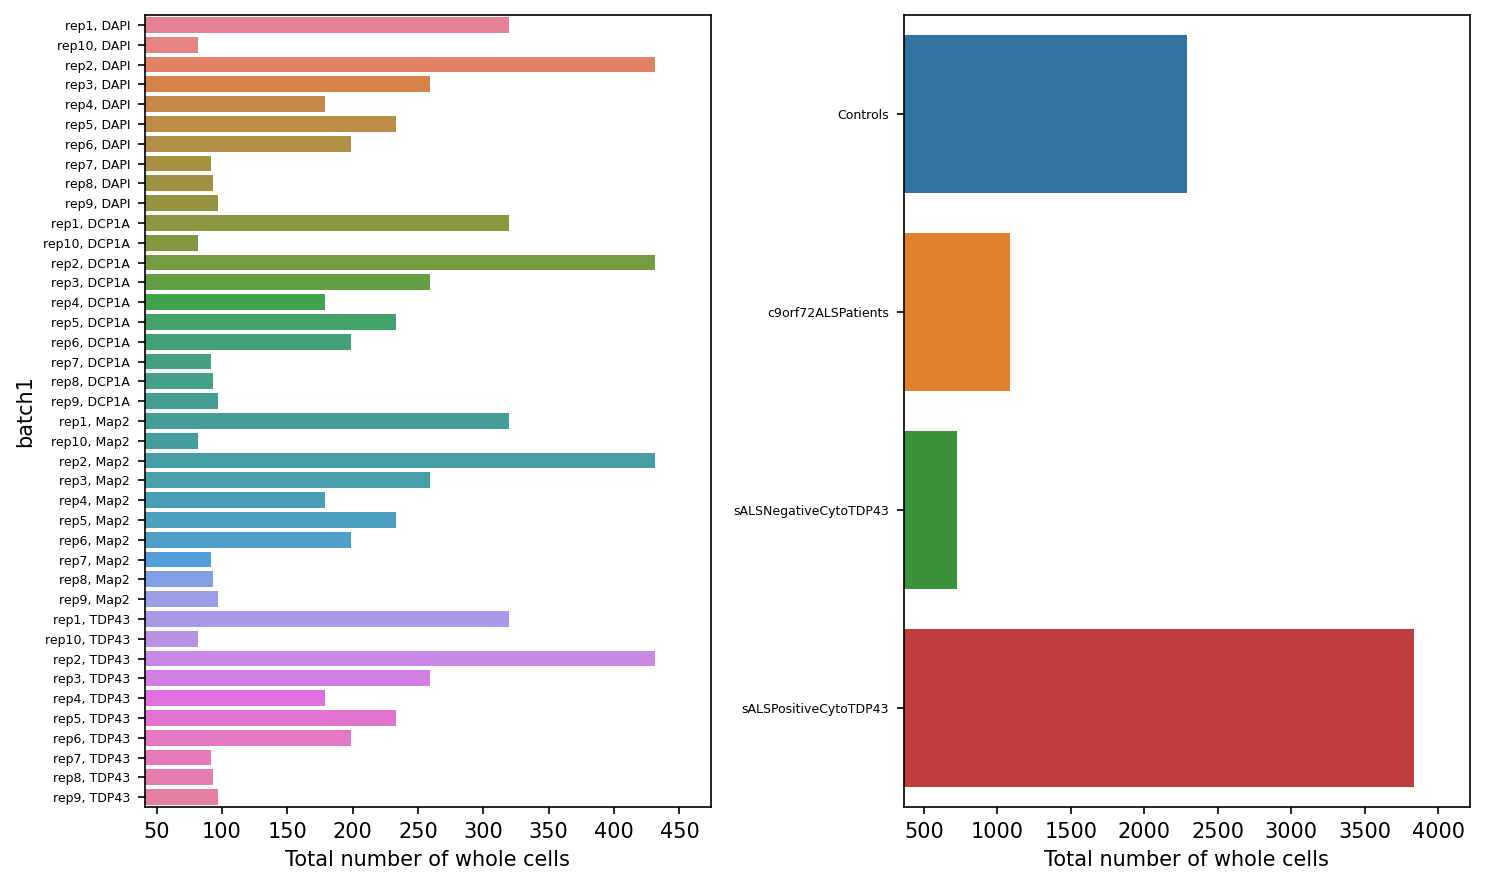

In [21]:
to_heatmap = total_sum.rename(columns={'site_whole_cells_counts_sum':'index'})
plot_filtering_heatmap(to_heatmap, extra_index='marker', vmin=None, vmax=None,
                      xlabel = 'Total number of whole cells', show_sum=True, figsize=(6,5))

### Show **Cell Count** Statistics per Batch

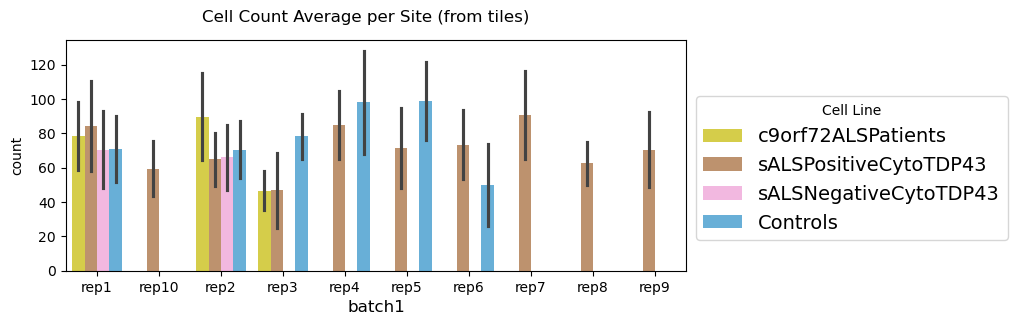

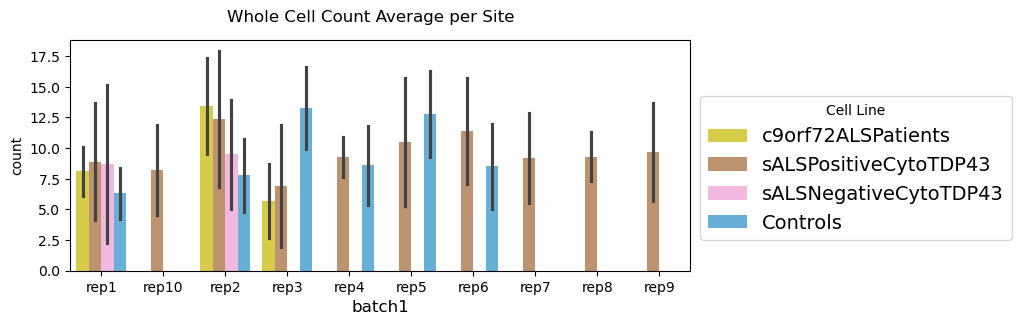

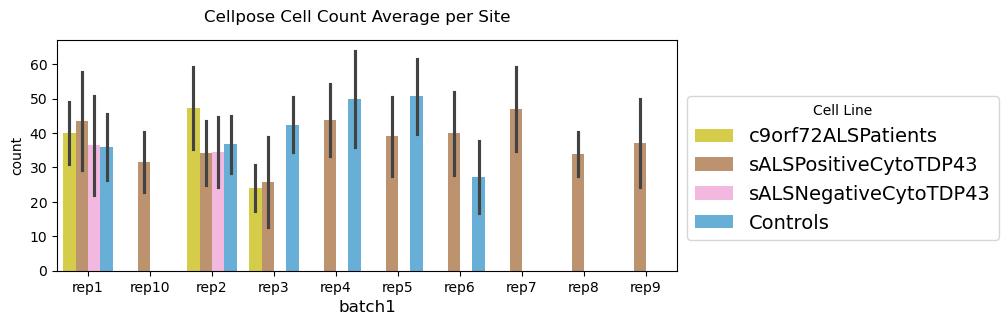

In [22]:
df_no_empty_sites = df_dapi[df_dapi.n_valid_tiles !=0]
plot_cell_count(df_no_empty_sites, AC_lines_order, AC_custom_palette, y='site_cell_count_sum', 
                title='Cell Count Average per Site (from tiles)', figsize=(8,3))

plot_cell_count(df_no_empty_sites, AC_lines_order, AC_custom_palette, y='site_whole_cells_counts_sum',
                title='Whole Cell Count Average per Site',figsize=(8,3))

plot_cell_count(df_no_empty_sites, AC_lines_order, AC_custom_palette, y='site_cell_count',
               title='Cellpose Cell Count Average per Site',figsize=(8,3))


### Show **Tiles** per Site Statistics


In [23]:
df_dapi.groupby(['cell_line_cond']).n_valid_tiles.mean()

cell_line_cond
Controls                 14.066667
c9orf72ALSPatients       14.633333
sALSNegativeCytoTDP43    14.250000
sALSPositiveCytoTDP43    13.830000
Name: n_valid_tiles, dtype: float64

/home/labs/hornsteinlab/Collaboration/NOVA_Oz/NOVA/tools/preprocessing_tools/qc_reports/qc_utils.py:1017: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'batch_rep'] = df['batch'] + " " + df['rep']


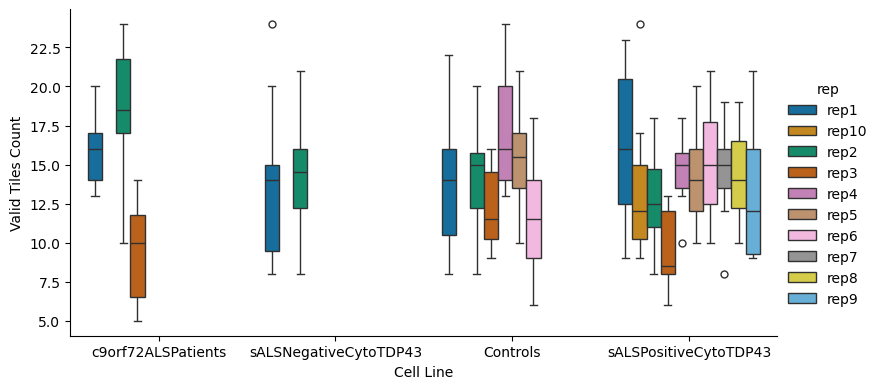

In [24]:
plot_catplot(df_dapi, sns.color_palette('colorblind'), reps=AC_reps,x='cell_line', y_title='Valid Tiles Count', x_title='Cell Line', y='n_valid_tiles', hue='rep',
             height=4, aspect=2)


### Show Mean of cell count in valid tiles

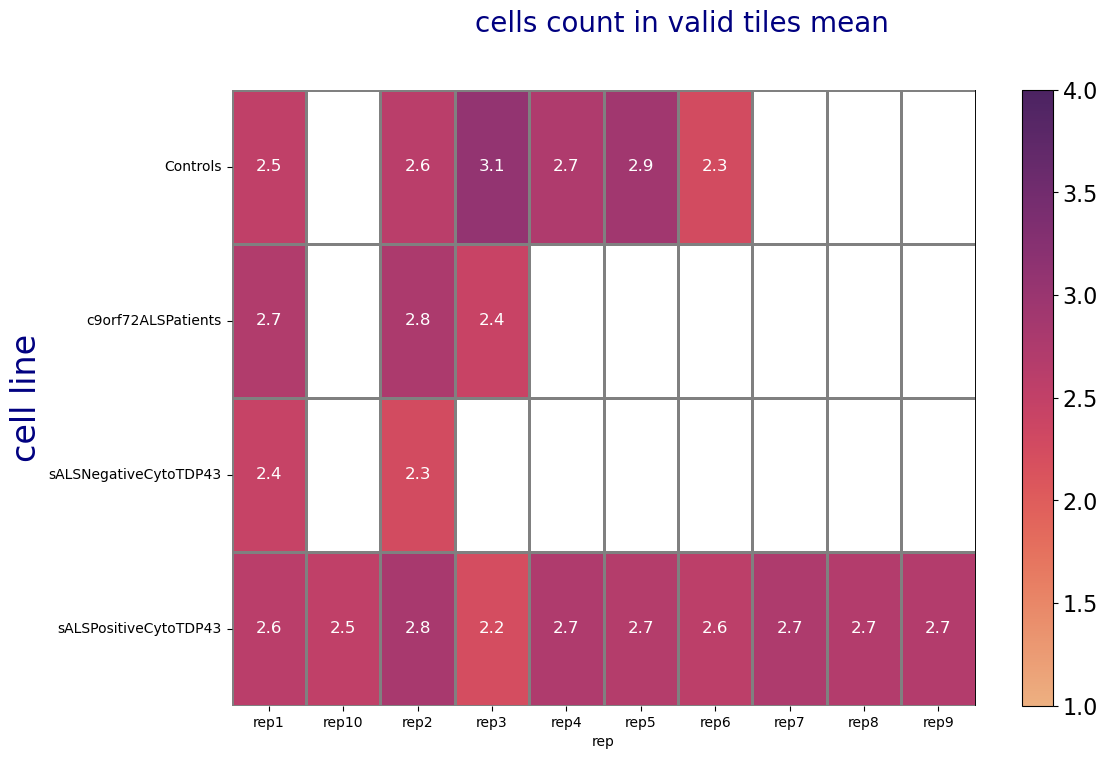

In [25]:
plot_hm(df_dapi, split_by=None,rows='cell_line', columns='rep')

# Assessing Staining Reproducibility and Outliers

batch1


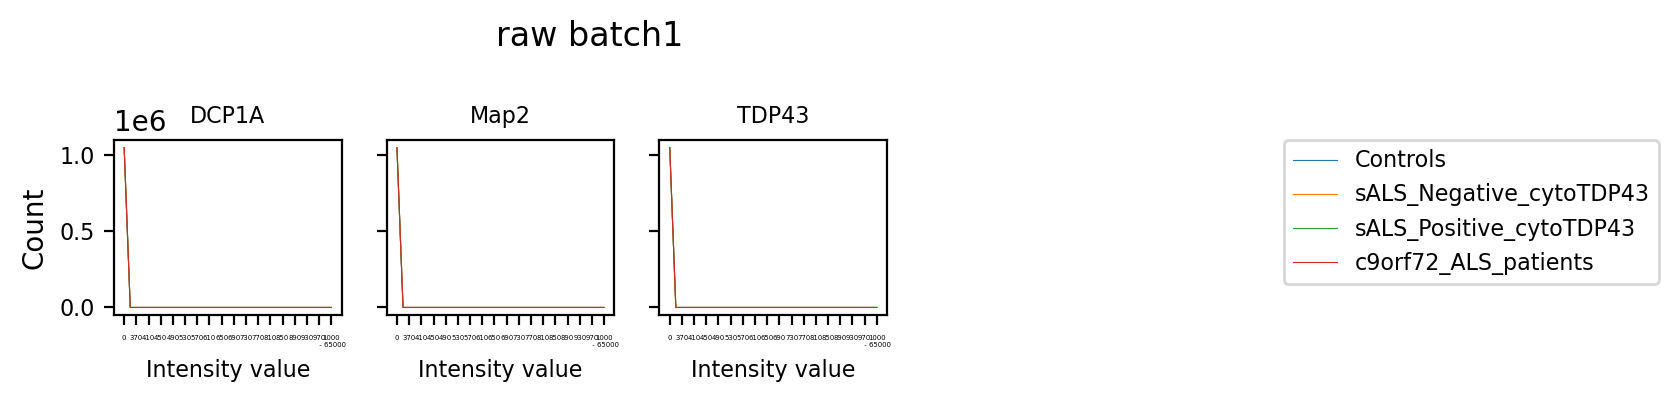

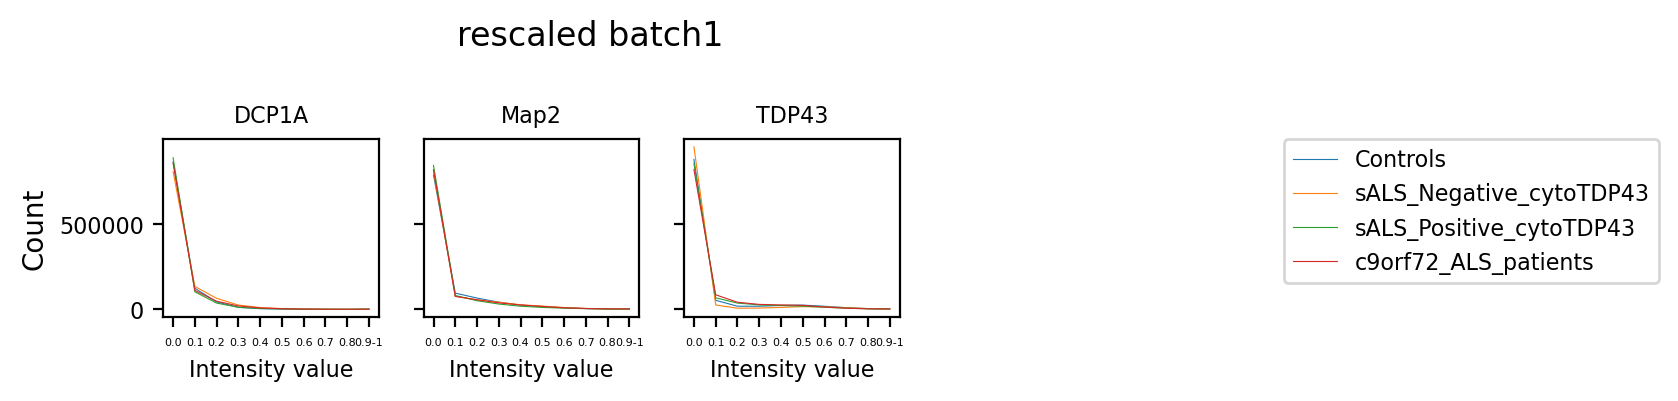

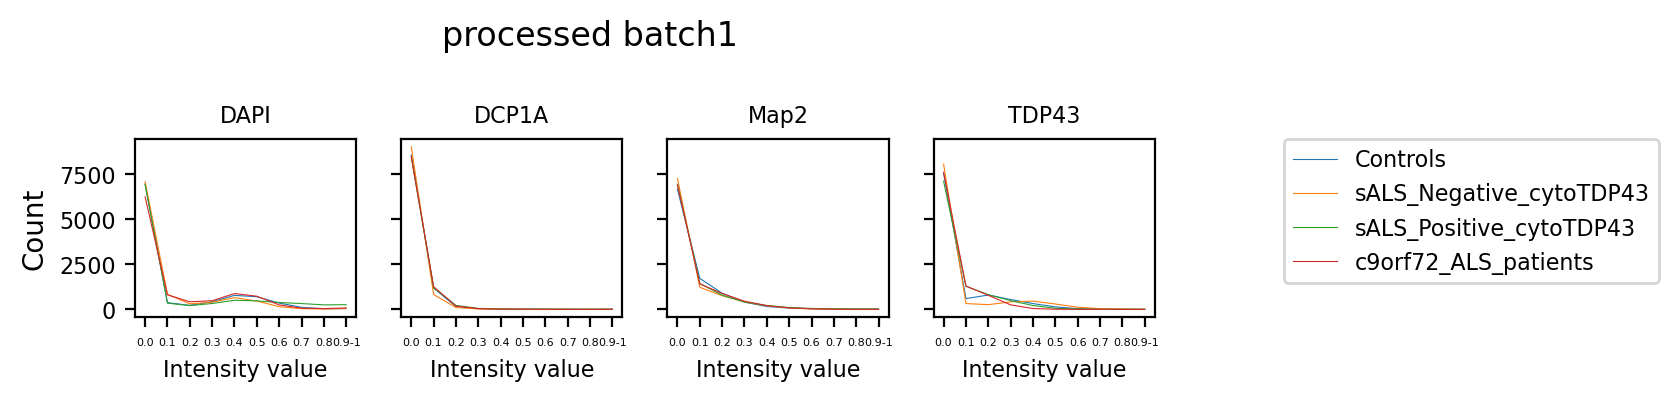

In [26]:
for batch in batches:
    print(batch)
    run_calc_hist_new(batch,AC_cell_lines_for_disp, AC_markers, root_directory_raw, root_directory_proc,
                           hist_sample=10,sample_size_per_markers=10, ncols=4, nrows=1, figsize=(6,2))
    print("="*30)
    

In [28]:
# save notebook as HTML ( the HTML will be saved in the same folder the original script is)
display(Javascript('IPython.notebook.save_checkpoint();'))
os.system(f'jupyter nbconvert --to html tools/preprocessing_tools/qc_reports/qc_report_CoyneLab_iPSC_patients_80pct.ipynb --output {NOVA_HOME}/manuscript/preprocessing_qc_reports/qc_report_CoyneLab_iPSC_patients_80pct.html')

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook tools/preprocessing_tools/qc_reports/qc_report_CoyneLab_iPSC_patients_80pct.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 19 image(s).
[NbConvertApp] Writing 2507060 bytes to /home/labs/hornsteinlab/Collaboration/NOVA_Oz/NOVA/manuscript/preprocessing_qc_reports/qc_report_CoyneLab_iPSC_patients_80pct.html


0